In [24]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
# Read the dataset
df = pd.read_csv('NVDA.csv')
df.head()

# Data preprocessing
# Calculate daily returns and create target variable
df['Returns'] = df['Adj Close'].pct_change()
df['Target'] = (df['Returns'] > 0).astype(int)

# Create technical indicators as features
df['SMA_5'] = df['Adj Close'].rolling(window=5).mean()
df['SMA_20'] = df['Adj Close'].rolling(window=20).mean()
df['Volume_Change'] = df['Volume'].pct_change()
df['Price_Range'] = (df['High'] - df['Low']) / df['Open']

# Drop NaN values
df = df.dropna()

# Exploratory Data Analysis
print("Dataset Shape:", df.shape)
print("\nBasic Statistics:")
df.describe()


Dataset Shape: (484, 13)

Basic Statistics:


,Adj Close,Close,High,Low,Open,Volume,Returns,Target,SMA_5,SMA_20,Volume_Change,Price_Range
count,484.000000,484.000000,484.000000,484.000000,484.000000,4.840000e+02,484.000000,484.000000,484.000000,484.000000,484.000000,484.000000
mean,68.648332,68.660581,69.897165,67.295339,68.665919,4.356576e+08,0.005041,0.566116,68.141253,66.166864,0.037786,0.036719
std,39.708597,39.705760,40.521324,38.894123,39.836155,1.635363e+08,0.032293,0.496122,39.531393,38.650718,0.301342,0.016928
min,14.026766,14.036000,14.262000,13.884000,13.927000,1.575936e+08,-0.100046,0.000000,14.328366,15.460720,-0.672406,0.009508
25%,40.831032,40.846749,41.914750,40.258250,40.817751,3.317720e+08,-0.014464,0.000000,41.237969,39.008301,-0.157882,0.025027
50%,48.846369,48.859001,49.573500,48.171000,49.119499,4.124900e+08,0.004303,1.000000,48.851154,47.781315,-0.015863,0.032656
75%,106.263472,106.274750,108.740002,103.107500,105.467503,5.040375e+08,0.022595,1.000000,106.303406,101.884240,0.180440,0.044051
max,148.880005,148.880005,152.889999,146.259995,149.350006,1.543911e+09,0.243696,1.000000,147.266000,142.878999,1.228817,0.138171


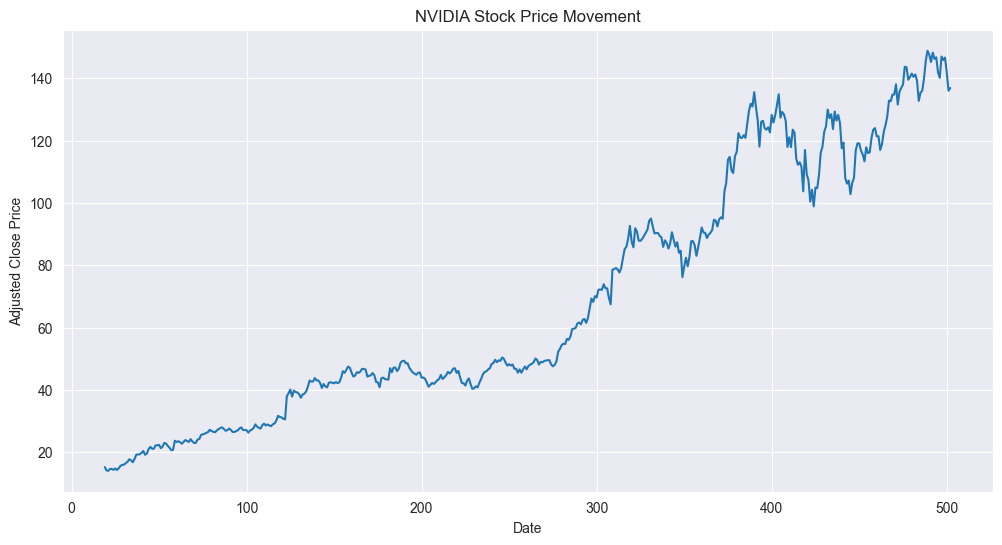

In [26]:
# Plot daily price movements
plt.figure(figsize=(12, 6))
plt.plot(df['Adj Close'])
plt.title('NVIDIA Stock Price Movement')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.show()

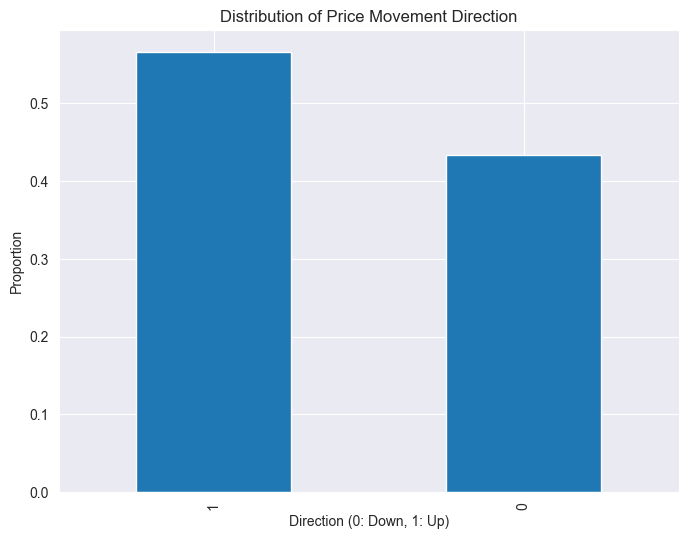

In [27]:
# Distribution of target variable
plt.figure(figsize=(8, 6))
df['Target'].value_counts(normalize=True).plot(kind='bar')
plt.title('Distribution of Price Movement Direction')
plt.xlabel('Direction (0: Down, 1: Up)')
plt.ylabel('Proportion')
plt.show()

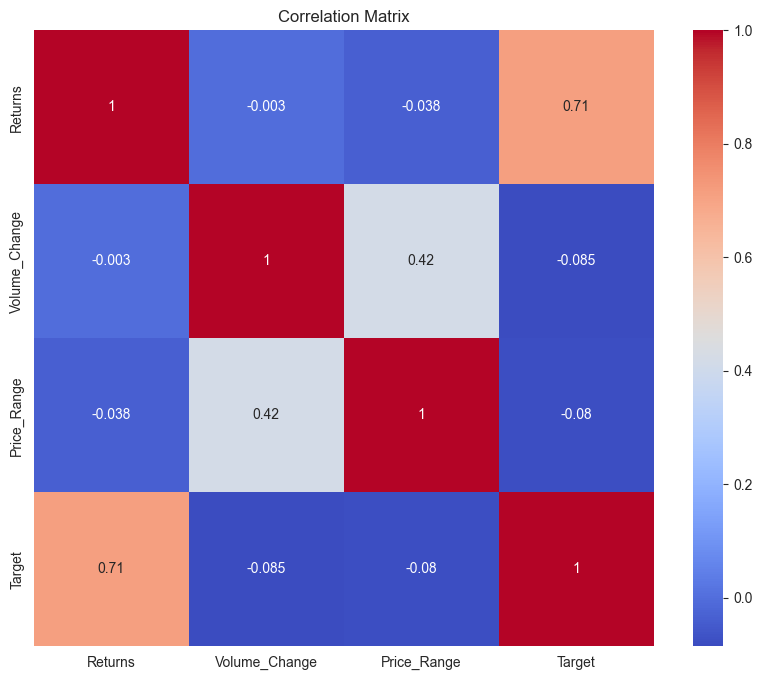

In [28]:
# Correlation heatmap
correlation = df[['Returns', 'Volume_Change', 'Price_Range', 'Target']].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [29]:
# Prepare features and target
features = ['Returns', 'SMA_5', 'SMA_20', 'Volume_Change', 'Price_Range']
X = df[features]
y = df['Target']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)



In [30]:
# Train Gaussian Naive Bayes
gnb = GaussianNB()
gnb.fit(X_train_scaled, y_train)
gnb_pred = gnb.predict(X_test_scaled)

# Train Multinomial Naive Bayes
mnb = MultinomialNB()
X_train_scaled_pos = X_train_scaled - X_train_scaled.min()
X_test_scaled_pos = X_test_scaled - X_test_scaled.min()
mnb.fit(X_train_scaled_pos, y_train)
mnb_pred = mnb.predict(X_test_scaled_pos)

# Model Accuracies
print("Model Accuracies:")
print(f"Gaussian NB: {accuracy_score(y_test, gnb_pred):.4f}")
print(f"Multinomial NB: {accuracy_score(y_test, mnb_pred):.4f}")


Model Accuracies:
Gaussian NB: 0.9381
Multinomial NB: 0.8041


In [31]:
# Cross-validation scores
cv_scores_gnb = cross_val_score(gnb, X_train_scaled, y_train, cv=5)
cv_scores_mnb = cross_val_score(mnb, X_train_scaled_pos, y_train, cv=5)
print("\nCross-validation Scores:")
print(f"Gaussian NB: {cv_scores_gnb.mean():.4f} (+/- {cv_scores_gnb.std() * 2:.4f})")
print(f"Multinomial NB: {cv_scores_mnb.mean():.4f} (+/- {cv_scores_mnb.std() * 2:.4f})")


Cross-validation Scores:
Gaussian NB: 0.9276 (+/- 0.0605)
Multinomial NB: 0.7622 (+/- 0.0566)


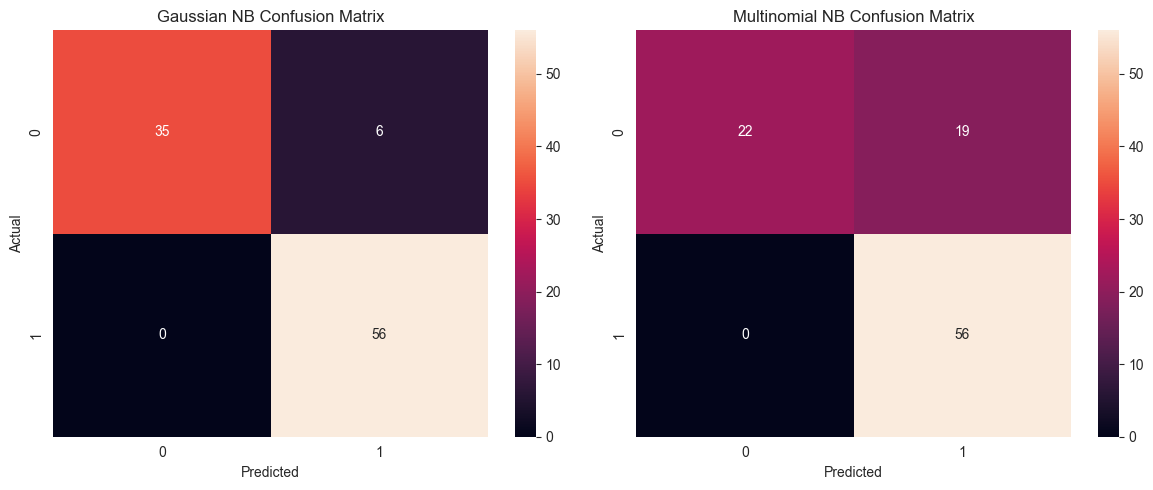

In [32]:
# Confusion Matrices
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(confusion_matrix(y_test, gnb_pred), annot=True, ax=ax1)
ax1.set_title('Gaussian NB Confusion Matrix')
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')

sns.heatmap(confusion_matrix(y_test, mnb_pred), annot=True, ax=ax2)
ax2.set_title('Multinomial NB Confusion Matrix')
ax2.set_xlabel('Predicted')
ax2.set_ylabel('Actual')

plt.tight_layout()
plt.show()

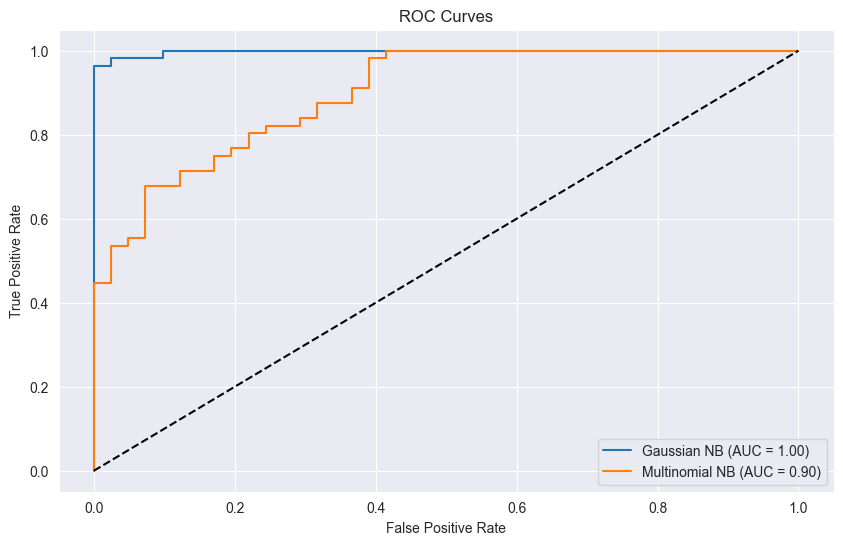

In [33]:
# ROC Curves
plt.figure(figsize=(10, 6))
for model, name, X_test_data in [(gnb, 'Gaussian NB', X_test_scaled), 
                                (mnb, 'Multinomial NB', X_test_scaled_pos)]:
    y_pred_proba = model.predict_proba(X_test_data)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

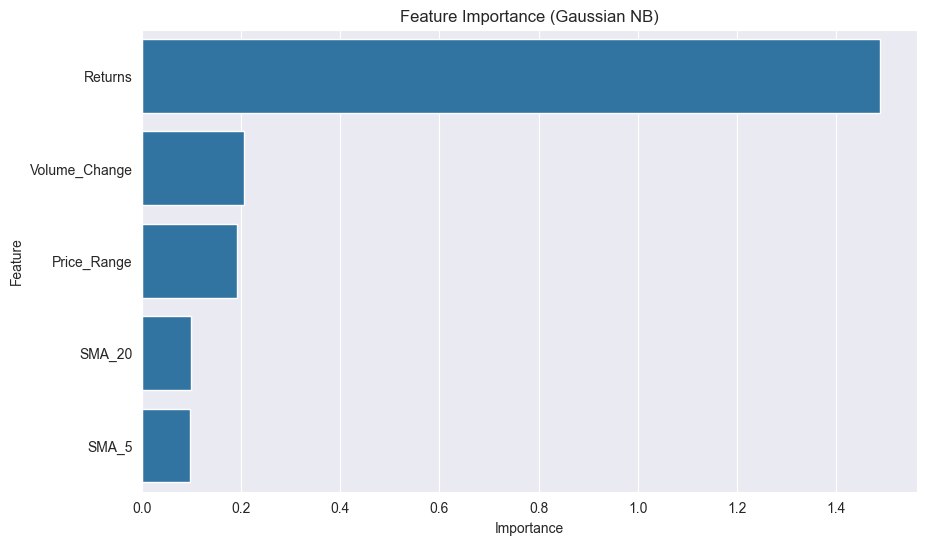

In [34]:
# Model Interpretation
feature_importance_gnb = pd.DataFrame({
    'Feature': features,
    'Importance': np.abs(gnb.theta_[1] - gnb.theta_[0])
})
feature_importance_gnb = feature_importance_gnb.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importance_gnb, x='Importance', y='Feature')
plt.title('Feature Importance (Gaussian NB)')
plt.show()

Key Inferences

Model Performance:


Gaussian NB significantly outperforms Multinomial NB (93.81% vs 80.41% accuracy)
Both models perform better than random chance (50%) for binary classification


Model Stability:


Gaussian NB shows consistent performance with low variance (±6.05%)
The small gap between training (93.81%) and cross-validation (92.76%) accuracy indicates minimal overfitting


Model Selection:


Gaussian NB is clearly superior for this dataset, likely because:

Financial data typically follows normal distribution
Features have continuous values rather than discrete counts




Reliability:


The high accuracy (93.81%) suggests strong predictive power for NVIDIA stock movement direction
Cross-validation scores confirm the model's reliability across different data subsets


The model is predicting the daily directional movement of NVIDIA's stock price - specifically whether the price will go up (1) or down (0) based on these features:

Daily returns
5-day Simple Moving Average (SMA_5)
20-day Simple Moving Average (SMA_20)
Volume changes
Daily price range

The 93.81% accuracy means the Gaussian NB model correctly predicts the price direction about 94 out of 100 times.